In [1]:
import numpy as np
import pandas as pd

from zipfile import ZipFile
from pathlib import Path

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical, Sequence
import tensorflow.keras.backend as K
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, 
                                     Conv2DTranspose, concatenate)

from tensorflow.keras.models import Model

In [2]:
!pip install gdown

In [3]:
!gdown --id 1WcvIGZDVtVqy_EXfABWqBkGC6AjF6W5r

Downloading...
From: https://drive.google.com/uc?id=1WcvIGZDVtVqy_EXfABWqBkGC6AjF6W5r
To: /kaggle/working/segmentation_full_body_mads_dataset_1192_img.zip
499MB [00:02, 225MB/s]  


1. Попробуйте обучить нейронную сеть U-Net на любом другом датасете. Можете взять один из этих наборов данных:  
https://www.kaggle.com/tapakah68/segmentation-full-body-mads-dataset

In [4]:
zp = ZipFile('/kaggle/working/segmentation_full_body_mads_dataset_1192_img.zip', 'r')
zp.extractall()

In [5]:
PATH_TO_IMG = 'segmentation_full_body_mads_dataset_1192_img/images'
PATH_TO_MASK = 'segmentation_full_body_mads_dataset_1192_img/masks'

In [6]:
images_paths = list(Path(PATH_TO_IMG).iterdir())
masks_paths = list(Path(PATH_TO_MASK).iterdir())

In [7]:
image_size = (512, 384)

In [8]:
n = int(len(images_paths) * 0.7)

X_train = images_paths[:n]
y_train = masks_paths[:n]

X_valid = images_paths[n:]
y_valid = masks_paths[n:]

In [9]:
color_map = [
    [255, 255, 255],
    [0, 0, 0]
]

In [10]:
def form_2D_label(mask,class_map):
    mask = mask.astype("uint8")
    label = np.zeros(mask.shape[:2],dtype= np.uint8)
    
    for i, rgb in enumerate(class_map):
        label[(mask == rgb).all(axis=2)] = i
    
    return label

In [11]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    
    def __init__(self, pair, class_map, batch_size=16, dim=(512,384,3), target_dim=(512,384,1), shuffle=False):
        'Initialization'
        self.dim = dim
        self.target_dim = target_dim
        self.pair = pair
        self.class_map = class_map
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.pair) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.pair))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        batch_imgs = list()
        batch_labels = list()

        # Generate data
        for i in list_IDs_temp:
            # Store sample
            img = load_img(self.pair[i][0] ,target_size=self.dim)
            img = img_to_array(img)/255.
            batch_imgs.append(img)

            label = load_img(self.pair[i][1],target_size=self.target_dim)
            label = img_to_array(label)
            label = form_2D_label(label,self.class_map)
            label = to_categorical(label , num_classes = 2)
            batch_labels.append(label)
            
        return np.array(batch_imgs) ,np.array(batch_labels)

In [12]:
train_generator = DataGenerator(tuple(zip(X_train, y_train)), color_map, batch_size=8)
valid_generator = DataGenerator(tuple(zip(X_valid, y_valid)), color_map, batch_size=8)

Human(255,255,255)  
background(0,0,0)

In [13]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred)) / (K.sum(y_true) + K.sum(y_pred))

In [14]:
def u_net(num_classes=2, input_shape=(512, 384, 3)):
    
    img_input = Input(input_shape)
    
    # block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)
    
    x = MaxPooling2D()(block_1_out)
    
    # block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)
    
    x = MaxPooling2D()(block_2_out)
    
    # block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)
    
    x = MaxPooling2D()(block_3_out)
    
    # block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)
#     x = MaxPooling2D()(block_4_out)
    
    # up 1
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # up 2
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # up 3
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)
    
    model = Model(img_input, x)
    
    return model

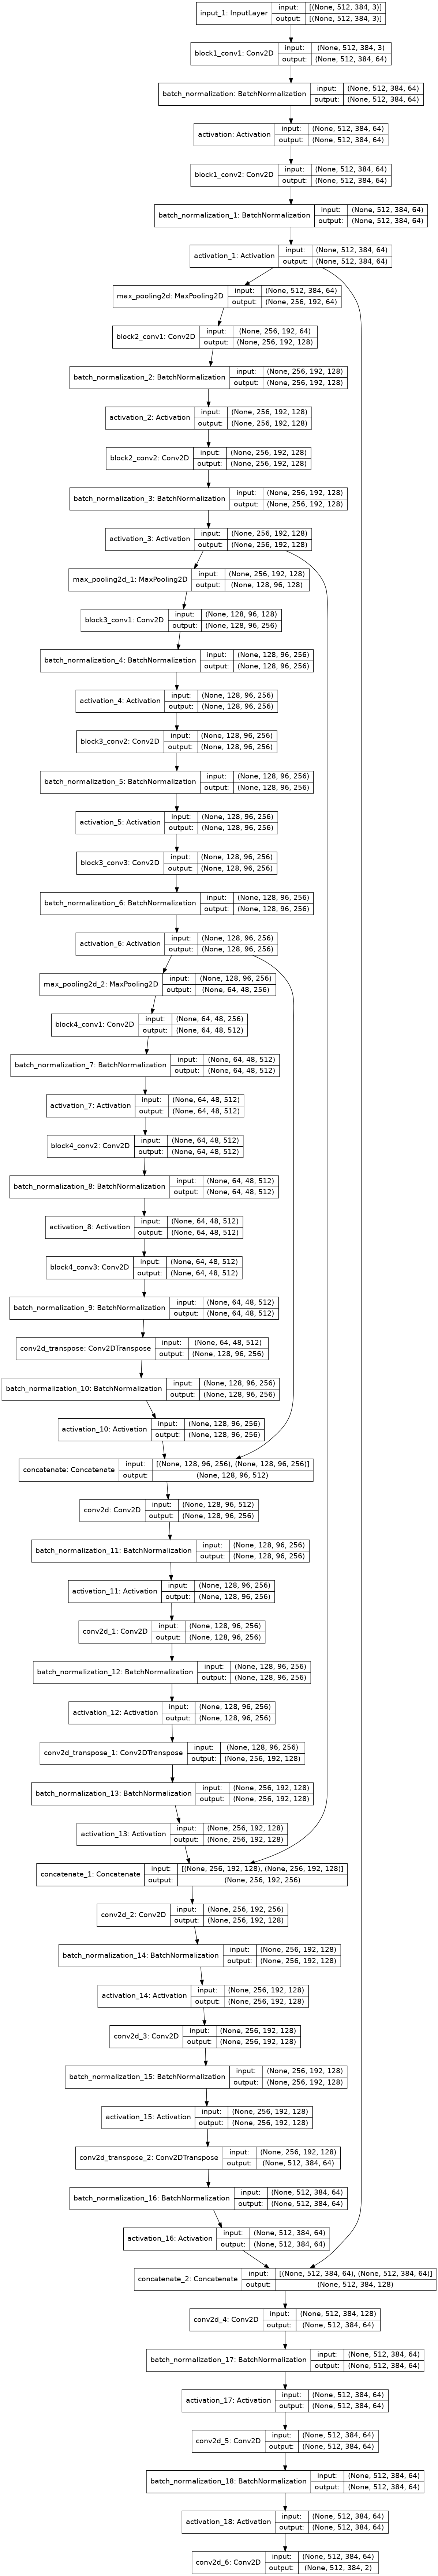

In [15]:
model_unet = u_net(2, (512, 384, 3))

keras.utils.plot_model(model_unet, to_file='model_unet.png', show_shapes=True)

In [16]:
model_unet.compile(optimizer=keras.optimizers.Adam(), 
                   loss='categorical_crossentropy', 
                   metrics=[dice_coef])
model_unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 384, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 384, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 384, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 384, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [17]:
sample_image, sample_mask = valid_generator.__getitem__(0)
sample_image, sample_mask = sample_image[0], sample_mask[0]

In [18]:
from IPython.display import clear_output


def show_predictions(model):
    pred_mask = model.predict(sample_image[None])[..., 0]
    print(pred_mask.shape)

    fig, ax = plt.subplots(1, 3, figsize=(15, 8))

    ax[0].imshow(sample_image)
    ax[1].imshow(sample_mask[..., 0])
    ax[2].imshow(np.squeeze(pred_mask, axis=0))
    plt.show()


class DisplayCallback(keras.callbacks.Callback):
    def __init__(self, patience=1):
        super().__init__()
        self.patience = patience
    
    def on_train_begin(self, logs=None):
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        self.wait += 1
        if self.wait >= self.patience:
            show_predictions(self.model)
            print(f'\nSample Prediction after epoch {epoch+1}')
            self.wait = 0

Epoch 1/20
104/104 [==============================] - 90s 794ms/step - loss: 0.1717 - dice_coef: 0.9077 - val_loss: 0.2115 - val_dice_coef: 0.9328
Epoch 2/20
104/104 [==============================] - 82s 784ms/step - loss: 0.0386 - dice_coef: 0.9815 - val_loss: 0.2417 - val_dice_coef: 0.8630
(1, 512, 384)


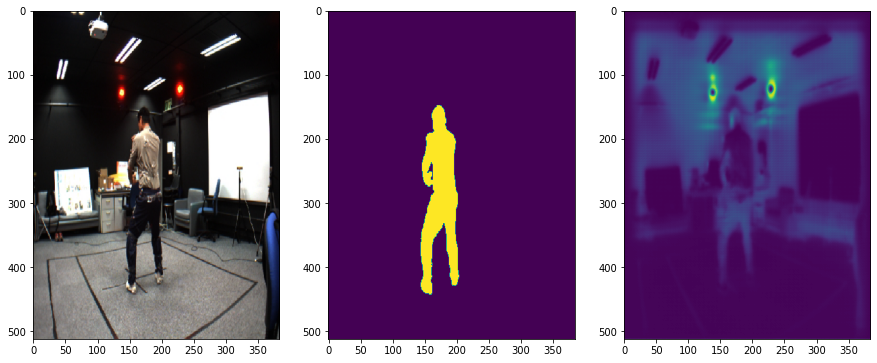


Sample Prediction after epoch 2
Epoch 3/20
104/104 [==============================] - 82s 783ms/step - loss: 0.0517 - dice_coef: 0.9772 - val_loss: 0.2042 - val_dice_coef: 0.9387
Epoch 4/20
104/104 [==============================] - 82s 787ms/step - loss: 0.0334 - dice_coef: 0.9853 - val_loss: 0.1990 - val_dice_coef: 0.9538
(1, 512, 384)


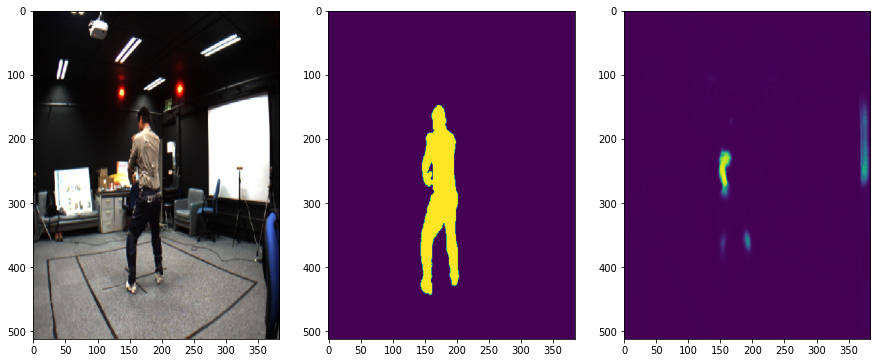


Sample Prediction after epoch 4
Epoch 5/20
104/104 [==============================] - 82s 783ms/step - loss: 0.0473 - dice_coef: 0.9822 - val_loss: 0.0850 - val_dice_coef: 0.9690
Epoch 6/20
104/104 [==============================] - 82s 787ms/step - loss: 0.0222 - dice_coef: 0.9913 - val_loss: 0.0627 - val_dice_coef: 0.9694
(1, 512, 384)


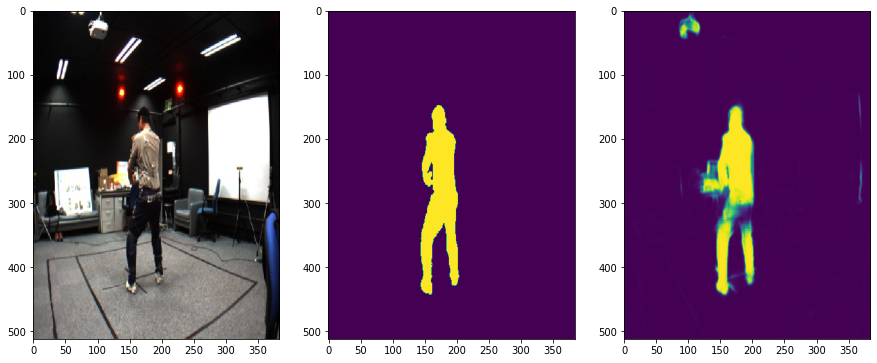


Sample Prediction after epoch 6
Epoch 7/20
104/104 [==============================] - 82s 787ms/step - loss: 0.0389 - dice_coef: 0.9860 - val_loss: 0.0178 - val_dice_coef: 0.9894
Epoch 8/20
104/104 [==============================] - 82s 790ms/step - loss: 0.0240 - dice_coef: 0.9912 - val_loss: 0.8712 - val_dice_coef: 0.7526
(1, 512, 384)


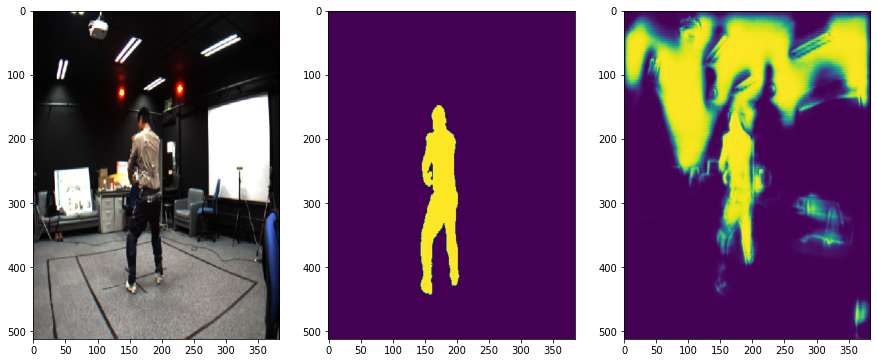


Sample Prediction after epoch 8
Epoch 9/20
104/104 [==============================] - 82s 784ms/step - loss: 0.0471 - dice_coef: 0.9827 - val_loss: 5.1538 - val_dice_coef: 0.3851
Epoch 10/20
104/104 [==============================] - 82s 785ms/step - loss: 0.0510 - dice_coef: 0.9818 - val_loss: 0.0251 - val_dice_coef: 0.9842
(1, 512, 384)


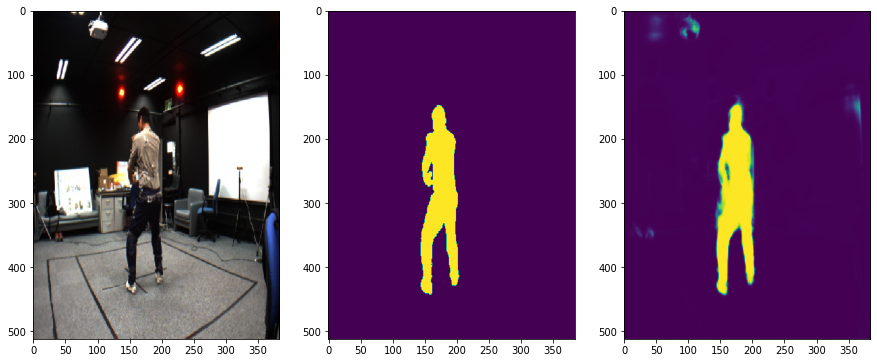


Sample Prediction after epoch 10
Epoch 11/20
104/104 [==============================] - 82s 785ms/step - loss: 0.0429 - dice_coef: 0.9849 - val_loss: 0.0124 - val_dice_coef: 0.9922
Epoch 12/20
104/104 [==============================] - 82s 790ms/step - loss: 0.0252 - dice_coef: 0.9907 - val_loss: 0.1008 - val_dice_coef: 0.9648
(1, 512, 384)


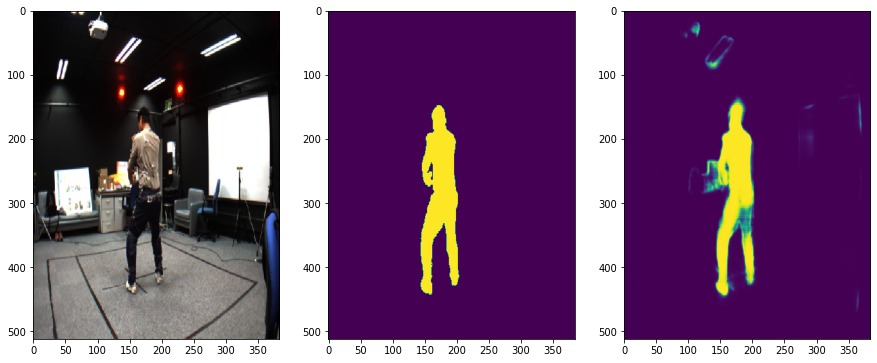


Sample Prediction after epoch 12
Epoch 13/20
104/104 [==============================] - 82s 788ms/step - loss: 0.0222 - dice_coef: 0.9917 - val_loss: 0.0346 - val_dice_coef: 0.9780
Epoch 14/20
104/104 [==============================] - 83s 792ms/step - loss: 0.0347 - dice_coef: 0.9853 - val_loss: 0.0128 - val_dice_coef: 0.9914
(1, 512, 384)


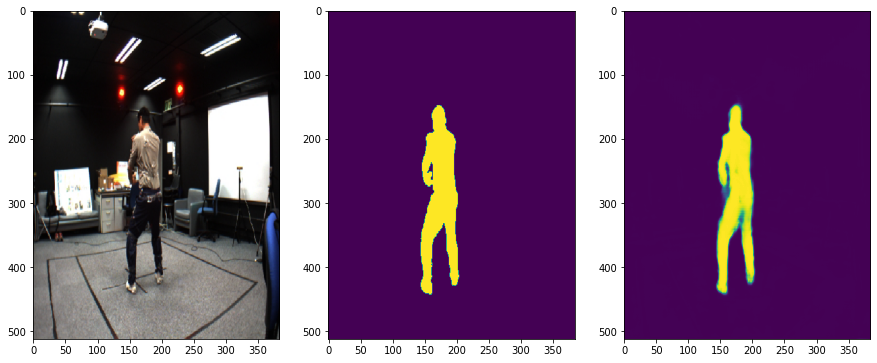


Sample Prediction after epoch 14
Epoch 15/20
104/104 [==============================] - 82s 784ms/step - loss: 0.0269 - dice_coef: 0.9901 - val_loss: 0.0114 - val_dice_coef: 0.9921
Epoch 16/20
104/104 [==============================] - 82s 785ms/step - loss: 0.0246 - dice_coef: 0.9911 - val_loss: 0.0152 - val_dice_coef: 0.9901
(1, 512, 384)


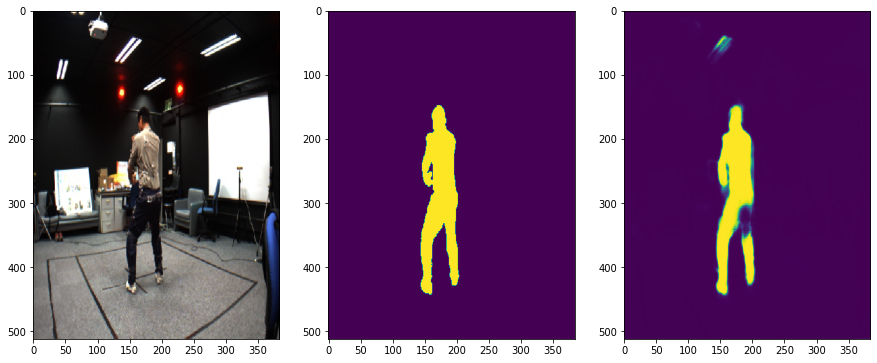


Sample Prediction after epoch 16
Epoch 17/20
104/104 [==============================] - 82s 784ms/step - loss: 0.0430 - dice_coef: 0.9856 - val_loss: 0.0108 - val_dice_coef: 0.9933
Epoch 18/20
104/104 [==============================] - 82s 786ms/step - loss: 0.0120 - dice_coef: 0.9942 - val_loss: 0.0184 - val_dice_coef: 0.9859
(1, 512, 384)


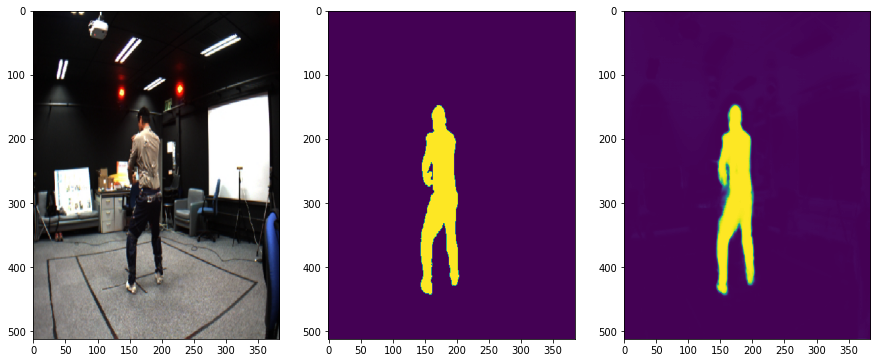


Sample Prediction after epoch 18
Epoch 19/20
104/104 [==============================] - 82s 786ms/step - loss: 0.0213 - dice_coef: 0.9880 - val_loss: 0.0678 - val_dice_coef: 0.9656
Epoch 20/20
104/104 [==============================] - 82s 788ms/step - loss: 0.0268 - dice_coef: 0.9889 - val_loss: 1.0251 - val_dice_coef: 0.7869
(1, 512, 384)


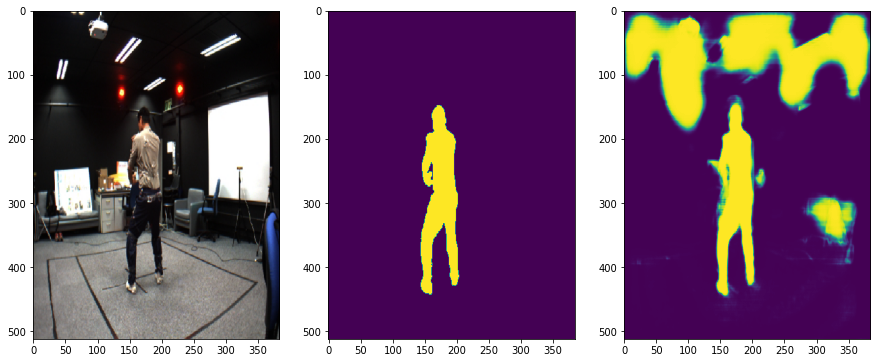


Sample Prediction after epoch 20


In [19]:
history = model_unet.fit(train_generator, 
                          epochs=20, 
                          validation_data=valid_generator, 
                          callbacks=[DisplayCallback(patience=2)]
                        )

2. Опишите в комментарии - какого результата вы добились от нейросети? Что помогло вам улучшить ее точность?